## IFT6390 Final Project: Binary Classification on Imbalanced Dataset

This notebook demostrates the application of three different supervised learning algorithms on imbalanced data classification problem:

- Support Vector Machines (with different kinds of kernels)
- Random Forest Classifier
- Multilayer Perceptron

We will use `sklearn` API, run these algorithms with different hyperparameters setting, evaluate model performance and answer the required research questions.

### 1. Import Required Packages

In [2]:
import os
import gc
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

%matplotlib inline

### 2. Load Data

In [3]:
# load bank data and bank data additional
bank_data = pd.read_csv('./mlproject/bank/bank-full.csv', sep=';')
bank_data_additional = pd.read_csv('./mlproject/bank/bank-additional-full.csv', sep=';')
bank_data_categorical_feats = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
                               'day', 'month', 'campaign', 'poutcome']
bank_data_additional_categorical_feats = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
                                          'day_of_week', 'month', 'campaign', 'poutcome']
bank_data_target_col = 'y'

# load income data (train and test)
income_data = pd.read_csv('./mlproject/income/adult.data', header=None)
income_data.columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
    'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]
income_data_categorical_feats = ['workclass', 'education', 'marital-status', 'occupation',
                                 'relationship', 'race', 'sex', 'native-country']
income_data_target_col = 'income'

income_data_test = pd.read_csv('./mlproject/income/adult.test')
income_data_test = income_data_test.reset_index()
income_data_test.columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
    'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

income_data_test = income_data_test.replace({' ?': np.nan}).dropna()

### 3. Preprocessing

All of these three supervised learning algorithms can only take numerical inputs, therefore the categorical features need to be encoded. Here we use one-hot encoding, with `pandas.get_dummies()` function.

In [4]:
bank_data[bank_data_target_col] = bank_data[bank_data_target_col].map({'no': 0, 'yes': 1})
bank_data_additional[bank_data_target_col] = bank_data_additional[bank_data_target_col].map({'no': 0, 'yes': 1})

income_data_train_size = income_data.shape[0]
income_data[income_data_target_col] = income_data[income_data_target_col].map({' <=50K': 0, ' >50K': 1})
income_data_test[income_data_target_col] = income_data_test[income_data_target_col].map({' <=50K.': 0, ' >50K.': 1})
income_data = pd.concat([income_data, income_data_test], axis=0)

In [5]:
# process bank data and bank data additional
bank_data_categorical_onehot = pd.get_dummies(bank_data[bank_data_categorical_feats])
bank_data_processed = pd.concat([bank_data, bank_data_categorical_onehot], axis=1)
bank_data_processed.drop(labels=bank_data_categorical_feats, axis=1, inplace=True)
bank_data_features = bank_data_processed[[c for c in bank_data_processed.columns if c != bank_data_target_col]]
bank_data_target = bank_data_processed[bank_data_target_col]

bank_data_additional_categorical_onehot = pd.get_dummies(bank_data_additional[bank_data_additional_categorical_feats])
bank_data_additional_processed = pd.concat([bank_data_additional, bank_data_additional_categorical_onehot], axis=1)
bank_data_additional_processed.drop(labels=bank_data_additional_categorical_feats, axis=1, inplace=True)
bank_data_additional_features = bank_data_additional_processed[[c for c in bank_data_additional_processed.columns if c != bank_data_target_col]]
bank_data_additional_target = bank_data_additional_processed[bank_data_target_col]

# process income data (train and test)
income_data_categorical_onehot = pd.get_dummies(income_data[income_data_categorical_feats])
income_data_processed = pd.concat([income_data, income_data_categorical_onehot], axis=1)
income_data_processed.drop(labels=income_data_categorical_feats, axis=1, inplace=True)
income_data_features = income_data_processed[[c for c in income_data_processed.columns if c != income_data_target_col]]
income_data_target = income_data_processed[income_data_target_col]

income_data_features_train = income_data_features.iloc[:income_data_train_size]
income_data_target_train = income_data_target.iloc[:income_data_train_size]
income_data_features_test = income_data_features.iloc[income_data_train_size:]
income_data_target_test = income_data_target.iloc[income_data_train_size:]

### 4. Running Models

For each algorithm, we will run multiple times with different hyperparameter settings, and use the 10 fold cross validation results for evaluation. Here in code we just show the run with default setting, we will list the results with different hyperparameters later.

In [6]:
def run_cv(df_train, y_train, df_test=None, y_test=None, method='rf', params=None, folds=10):
    """ Run k-folds cross validation """
    kfold = KFold(n_splits=folds, shuffle=True, random_state=2019)
    oof_preds = np.zeros(df_train.shape[0])
    
    if params is None:
        params = {}
    if not isinstance(params, dict):
        raise ValueError('Argument `params` has to be dictionary or None by default')
    
    for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(df_train, y_train)):
        X_train_ = df_train.iloc[trn_idx]
        y_train_ = y_train.iloc[trn_idx]
        
        X_val_ = df_train.iloc[val_idx]
        y_val_ = y_train.iloc[val_idx]
        
        if method == 'svm':
            clf = SVC(**params)
        elif method == 'rf':
            clf = RandomForestClassifier(**params)
        elif method== 'mlp':
            clf = MLPClassifier(**params)
        else:
            raise ValueError('Only support method in [`svm`, `rf`, `mlp`]')
            
        clf.fit(X_train_, y_train_)
        oof_preds[val_idx] = clf.predict(X_val_)
    
    print('-'*20, 'Cross validation performance', '-'*20)
    print('Training : Validation = {:.1f} : 1'.format(y_train_.shape[0] / y_val_.shape[0]))
    print('Accuracy score = {:.2f} %'.format(100 * accuracy_score(y_train.values, oof_preds)))
    if df_test is not None and y_test is not None:
        test_preds = clf.predict(df_test.values)
        print('-'*20, 'Test performance', '-'*20)
        print('Training : Testing = {:.1f} : 1'.format(y_train.shape[0] / y_test.shape[0]))
        print('Accuracy score = {:.2f} %'.format(100 * accuracy_score(y_test.values, test_preds)))

#### 4.1 Support Vector Machine

Running on bank data.

In [26]:
params = {}
run_cv(bank_data_features, bank_data_target, method='svm', params=params)

-------------------- Cross validation performance --------------------
Training : Validation = 9.0 : 1
Accuracy score = 88.29 %


In [27]:
params = {}
run_cv(bank_data_additional_features, bank_data_additional_target, method='svm', params=params)

-------------------- Cross validation performance --------------------
Training : Validation = 9.0 : 1
Accuracy score = 89.76 %


Running on income data

In [28]:
params = {}
run_cv(income_data_features_train,
       income_data_target_train,
       income_data_features_test,
       income_data_target_test,
       method='svm',
       params=params)

-------------------- Cross validation performance --------------------
Training : Validation = 9.0 : 1
Accuracy score = 75.63 %
-------------------- Test performance --------------------
Training : Testing = 2.2 : 1
Accuracy score = 75.05 %


#### 4.2 Random Forest

Running on bank data

In [19]:
params = {}
run_cv(bank_data_features, bank_data_target, method='rf', params=params)

-------------------- Cross validation performance --------------------
Training : Validation = 9.0 : 1
Accuracy score = 89.98 %


In [20]:
params = {}
run_cv(bank_data_additional_features, bank_data_additional_target, method='rf', params=params)

-------------------- Cross validation performance --------------------
Training : Validation = 9.0 : 1
Accuracy score = 90.80 %


Running on income data

In [21]:
params = {}
run_cv(income_data_features_train,
       income_data_target_train,
       income_data_features_test,
       income_data_target_test,
       method='rf',
       params=params)

-------------------- Cross validation performance --------------------
Training : Validation = 9.0 : 1
Accuracy score = 84.75 %
-------------------- Test performance --------------------
Training : Testing = 2.2: 1
Accuracy score = 83.82 %


#### 4.3 Multilayer Perceptron

Running on bank data.

In [23]:
params = {}
run_cv(bank_data_features, bank_data_target, method='mlp', params=params)

-------------------- Cross validation performance --------------------
Training : Validation = 9.0 : 1
Accuracy score = 88.37 %


In [24]:
params = {}
run_cv(bank_data_additional_features, bank_data_additional_target, method='mlp', params=params)

-------------------- Cross validation performance --------------------
Training : Validation = 9.0 : 1
Accuracy score = 87.92 %


Running on income data.

In [25]:
params = {}
run_cv(income_data_features_train,
       income_data_target_train,
       income_data_features_test,
       income_data_target_test,
       method='mlp',
       params=params)

-------------------- Cross validation performance --------------------
Training : Validation = 9.0 : 1
Accuracy score = 72.50 %
-------------------- Test performance --------------------
Training : Testing = 2.2 : 1
Accuracy score = 79.93 %


### 5. Research Questions and Suggestions

- Which algorithm is theoretically more likely to overfit? What happens in practice?

Multilayer perceptron is theoretically more likely to overfit. Multilayer perceptron is one type of neural network, and theoretically it is able to approximate any type of functions, therefore it is more likely to fit "noise" in the training data. In practice, a neural network will probably get large test error on test data if it overfits on training data.

- What prior assumptions are encoded by your chosen algorithms? Are these ’good’ assumptions?

SVM: the assumption depends on the kernel. If the kernel function is linear, then it assume the data is linear separable. Also SVM can only take numerical inputs, there is no other assumptions related to the data (like i.i.d. or normality).

Random forest: random forest is an ensemble algorithm with decision tree as weak learner, and decision tree is a non-parametric algorithm. Same with SVM, it has to take numerical inputs, there is no requirment for the data distributions.

Multilayer perceptron: same with SVM and random forest, there are no statistical assumptions needed for multilayer perceptron. But to achieve good results, neural networks require large amoun
 

- Compare the performance (accuracy, log-likelihood...) of the different algorithms on each
dataset. Is one consistently better than others? Why?

Here we select top 3 best results for each algorithm. 

Performance on bank data

SVM:

```
C   kernel  gamma  cv_accuracy
10  rbf     0.0001 89.12
10  rbf     scale  89.05
5   rbf     scale  88.84
```

Random forest:

```
n_estimators  criterion  max_depth  min_samples_split  min_samples_leaf cv_accuracy
1500          gini       None       2                  1                90.51
1000          gini       None       2                  1                90.54
500           gini       None       2                  1                90.52
```

Multilayer perceptron:

```
structure      batch_size  cv_accuracy
100, 100       256         89.87
200, 100       256         89.99
200, 200       256         90.08
```

Performance on bank data additional

SVM:

```
C   kernel  gamma  cv_accuracy
10  rbf     0.0001 89.95
10  rbf     scale  89.84
5   rbf     scale  89.71
```

Random forest:

```
n_estimators  criterion  max_depth  min_samples_split  min_samples_leaf cv_accuracy 
1500          gini       None       2                  1                91.26  
1000          gini       None       2                  1                91.24
500           gini       None       2                  1                91.26
```

Multilayer perceptron:

```
structure      batch_size  cv_accuracy
100, 100       256         90.24
200, 100       256         90.38
200, 200       256         91.12       
```

So we can see that multilayer perceptron and random forest are consistently better than SVM, but we cannot conclude which one is better between multilayer perceptron and random forest. Also, we see better accuracy score on bank data additional, this could be the reason that bank data additional has more and better features, although the samples are different.

Performance on income data

SVM:

```
C   kernel  gamma  cv_accuracy test_accuracy
10  rbf     scale  76.45       75.88
1   rbf     scale  75.63       75.05
10  rbf     0.0001 76.78       76.12
```

Random forest:

```
n_estimators  criterion  max_depth  min_samples_split  min_samples_leaf cv_accuracy test_accuracy
1500          gini       None       2                  1                85.45       84.66
1500          gini       None       10                 1                85.48       84.73  
1500          gini       None       20                 5                85.49       84.76
```


Multilayer perceptron:

```
structure      batch_size  cv_accuracy test_accuracy
100, 100       256         72.98       79.54
200, 100       256         74.56       79.68
200, 200       256         75.52       79.72      
```

We can get the same conclusion with bank data. We actually tried both 5 folds and 10 folds cross validation experiments, we can find that 10 folds cross validation could produce better accuracy, the reason could be that there are more training data in 10 folds cases.

Some visualization about model performance (we pick random forest since it has the best performance)

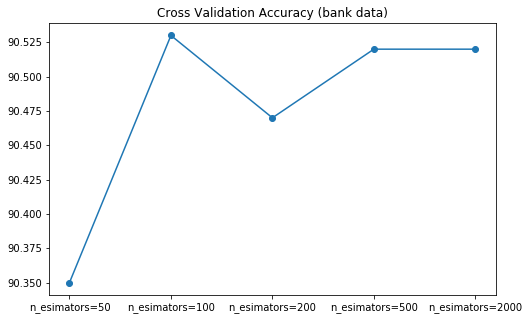

In [24]:
# n_estimators = 50, 100, 200, 500, 2000
n = 5
loc = np.arange(n)
acc = [90.35, 90.53, 90.47, 90.52, 90.52]
fig = plt.figure(figsize=(8, 5))
_ = plt.plot(loc, acc, 'o-')
_ = plt.xticks(loc, ['n_esimators=50', 'n_esimators=100', 'n_esimators=200', 'n_esimators=500', 'n_esimators=2000'])
_ = plt.title('Cross Validation Accuracy (bank data)')

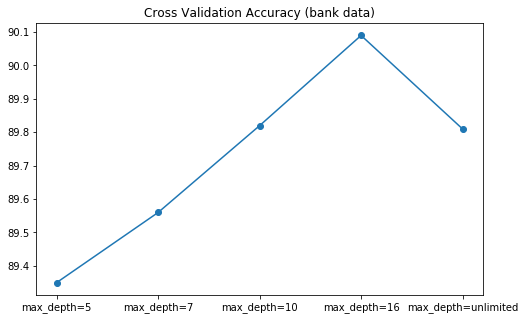

In [25]:
# max_depth = 5, 7, 10, 16, unlimited
n = 5
loc = np.arange(n)
acc = [89.35, 89.56, 89.82, 90.09, 89.81]
fig = plt.figure(figsize=(8, 5))
_ = plt.plot(loc, acc, 'o-')
_ = plt.xticks(loc, ['max_depth=5', 'max_depth=7', 'max_depth=10', 'max_depth=16', 'max_depth=unlimited'])
_ = plt.title('Cross Validation Accuracy (bank data)')

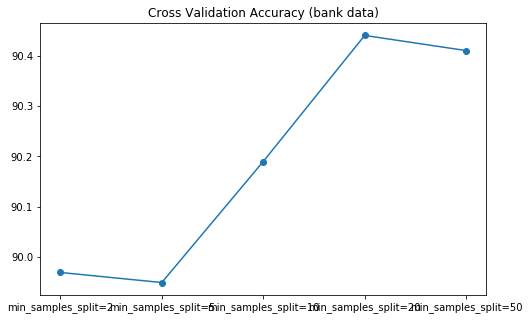

In [26]:
# min_samples_split = 2, 5, 10, 20, 50
n = 5
loc = np.arange(n)
acc = [89.97, 89.95, 90.19, 90.44, 90.41]
fig = plt.figure(figsize=(8, 5))
_ = plt.plot(loc, acc, 'o-')
_ = plt.xticks(loc, ['min_samples_split=2', 'min_samples_split=5', 'min_samples_split=10', 'min_samples_split=20', 'min_samples_split=50'])
_ = plt.title('Cross Validation Accuracy (bank data)')

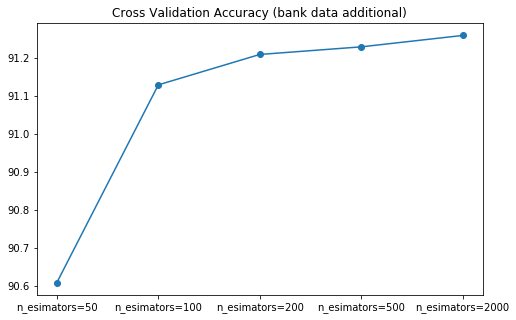

In [27]:
# n_estimators = 10, 50, 100, 500, 2000
n = 5
loc = np.arange(n)
acc = [90.61, 91.13, 91.21, 91.23, 91.26]
fig = plt.figure(figsize=(8, 5))
_ = plt.plot(loc, acc, 'o-')
_ = plt.xticks(loc, ['n_esimators=50', 'n_esimators=100', 'n_esimators=200', 'n_esimators=500', 'n_esimators=2000'])
_ = plt.title('Cross Validation Accuracy (bank data additional)')

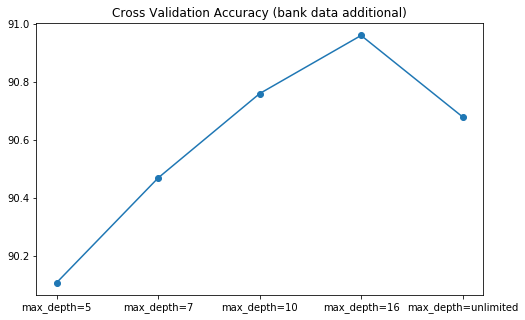

In [33]:
# max_depth = 5, 7, 10, 16, unlimited
n = 5
loc = np.arange(n)
acc = [90.11, 90.47, 90.76, 90.96, 90.68]
fig = plt.figure(figsize=(8, 5))
_ = plt.plot(loc, acc, 'o-')
_ = plt.xticks(loc, ['max_depth=5', 'max_depth=7', 'max_depth=10', 'max_depth=16', 'max_depth=unlimited'])
_ = plt.title('Cross Validation Accuracy (bank data additional)')

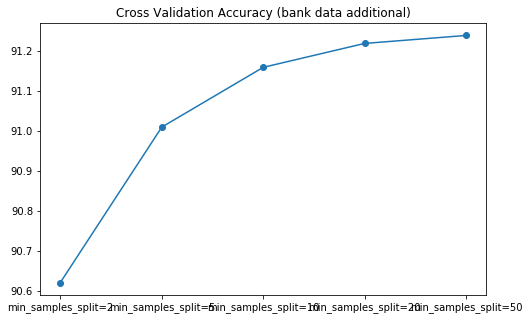

In [34]:
# min_samples_split = 2, 5, 10, 20, 50
n = 5
loc = np.arange(n)
acc = [90.62, 91.01, 91.16, 91.22, 91.24]
fig = plt.figure(figsize=(8, 5))
_ = plt.plot(loc, acc, 'o-')
_ = plt.xticks(loc, ['min_samples_split=2', 'min_samples_split=5', 'min_samples_split=10', 'min_samples_split=20', 'min_samples_split=50'])
_ = plt.title('Cross Validation Accuracy (bank data additional)')

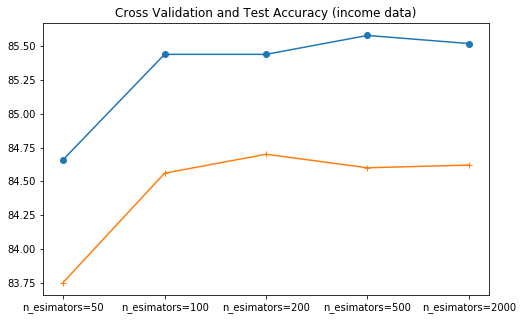

In [35]:
# n_estimators = 10, 50, 100, 500, 2000
n = 5
loc = np.arange(n)
cv_acc = [84.66, 85.44, 85.44, 85.58, 85.52]
test_acc = [83.75, 84.56, 84.70, 84.60, 84.62]
fig = plt.figure(figsize=(8, 5))
_ = plt.plot(loc, cv_acc, 'o-', loc, test_acc, '+-')
_ = plt.xticks(loc, ['n_esimators=50', 'n_esimators=100', 'n_esimators=200', 'n_esimators=500', 'n_esimators=2000'])
_ = plt.title('Cross Validation and Test Accuracy (income data)')

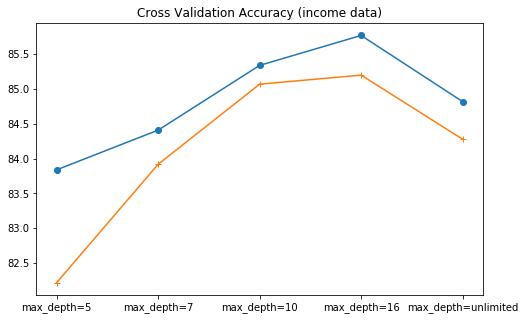

In [36]:
# max_depth = 5, 7, 10, 16, unlimited
n = 5
loc = np.arange(n)
cv_acc = [83.84, 84.41, 85.34, 85.77, 84.82]
test_acc = [82.22, 83.92, 85.07, 85.20, 84.28]
fig = plt.figure(figsize=(8, 5))
_ = plt.plot(loc, cv_acc, 'o-', loc, test_acc, '+-')
_ = plt.xticks(loc, ['max_depth=5', 'max_depth=7', 'max_depth=10', 'max_depth=16', 'max_depth=unlimited'])
_ = plt.title('Cross Validation Accuracy (income data)')

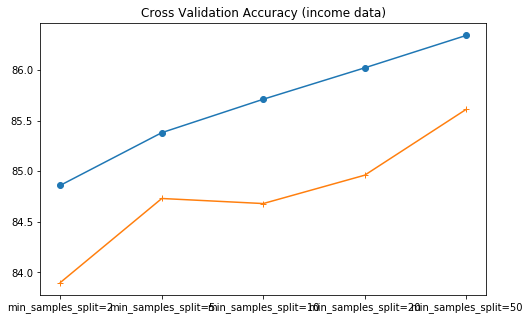

In [37]:
# min_samples_split = 2, 5, 10, 20, 50
n = 5
loc = np.arange(n)
cv_acc = [84.86, 85.38, 85.71, 86.02, 86.34]
test_acc = [83.90, 84.73, 84.68, 84.96, 85.61]
fig = plt.figure(figsize=(8, 5))
_ = plt.plot(loc, cv_acc, 'o-', loc, test_acc, '+-')
_ = plt.xticks(loc, ['min_samples_split=2', 'min_samples_split=5', 'min_samples_split=10', 'min_samples_split=20', 'min_samples_split=50'])
_ = plt.title('Cross Validation Accuracy (income data)')

- Explore your data - provide simple statistics and/or analysis like the mean, variance, (possibly
over different features), visualizations of how features vary over classes, etc. Do any of these
properties help explain different algorithms’ performance? Compare statistics between your
datasets - is one more balanced than another? Is this a good thing?

In [21]:
# numerical statistics of bank data
bank_data.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [27]:
# numerical statistics over different target classes
bank_data.groupby(['y']).describe().T

y                           0             1
age      count   39922.000000   5289.000000
         mean       40.838986     41.670070
         std        10.172662     13.497781
         min        18.000000     18.000000
         25%        33.000000     31.000000
         50%        39.000000     38.000000
         75%        48.000000     50.000000
         max        95.000000     95.000000
balance  count   39922.000000   5289.000000
         mean     1303.714969   1804.267915
         std      2974.195473   3501.104777
         min     -8019.000000  -3058.000000
         25%        58.000000    210.000000
         50%       417.000000    733.000000
         75%      1345.000000   2159.000000
         max    102127.000000  81204.000000
day      count   39922.000000   5289.000000
         mean       15.892290     15.158253
         std         8.294728      8.501875
         min         1.000000      1.000000
         25%         8.000000      8.000000
         50%        16.000000     15.000000
         75%        21.000000     22.000000
         max        31.000000     31.000000
duration count   39922.000000   5289.000000
         mean      221.182806    537.294574
         std       207.383237    392.525262
         min         0.000000      8.000000
         25%        95.000000    244.000000
         50%       164.000000    426.000000
         75%       279.000000    725.000000
         max      4918.000000   3881.000000
campaign count   39922.000000   5289.000000
         mean        2.846350      2.141047
         std         3.212767      1.921826
         min         1.000000      1.000000
         25%         1.000000      1.000000
         50%         2.000000      2.000000
         75%         3.000000      3.000000
         max        63.000000     32.000000
pdays    count   39922.000000   5289.000000
         mean       36.421372     68.702968
         std        96.757135    118.822266
         min        -1.000000     -1.000000
         25%        -1.000000     -1.000000
         50%        -1.000000     -1.000000
         75%        -1.000000     98.000000
         max       871.000000    854.000000
previous count   39922.000000   5289.000000
         mean        0.502154      1.170354
         std         2.256771      2.553272
         min         0.000000      0.000000
         25%         0.000000      0.000000
         50%         0.000000      0.000000
         75%         0.000000      1.000000
         max       275.000000     58.000000

Based on these statistics, we can plot some features which we think are significantly different over different classes 

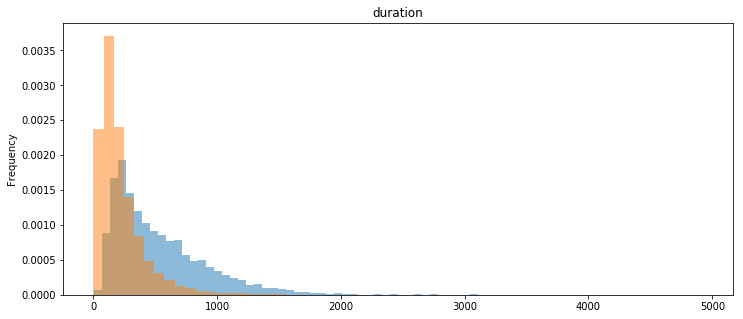

In [49]:
plot_feature = 'duration'
axes = bank_data.loc[bank_data['y'] == 1][plot_feature].plot(kind='hist',
                                                             alpha=.5,
                                                             density=True,
                                                             bins=60,
                                                             figsize=(12, 5),
                                                             title=plot_feature)
bank_data.loc[bank_data['y'] == 0][plot_feature].plot(ax=axes, kind='hist', alpha=.5, density=True, bins=60)

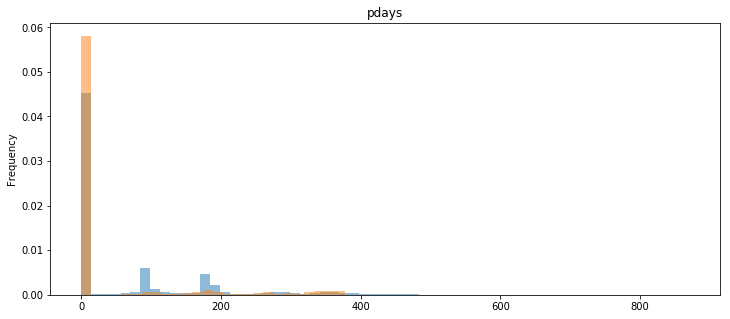

In [50]:
plot_feature = 'pdays'
axes = bank_data.loc[bank_data['y'] == 1][plot_feature].plot(kind='hist',
                                                             alpha=.5,
                                                             density=True,
                                                             bins=60,
                                                             figsize=(12, 5),
                                                             title=plot_feature)
bank_data.loc[bank_data['y'] == 0][plot_feature].plot(ax=axes, kind='hist', alpha=.5, density=True, bins=60)

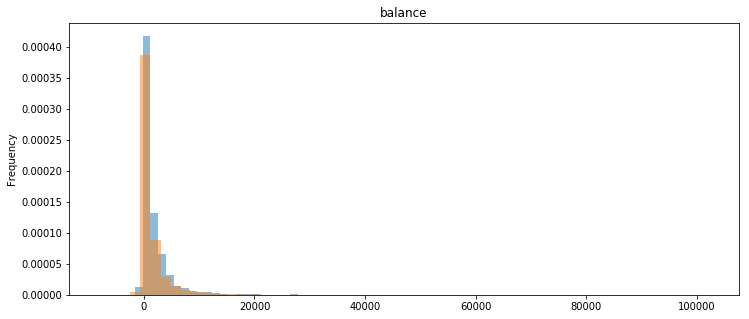

In [77]:
plot_feature = 'balance'
axes = bank_data.loc[bank_data['y'] == 1][plot_feature].plot(kind='hist',
                                                             alpha=.5,
                                                             density=True,
                                                             bins=60,
                                                             figsize=(12, 5),
                                                             title=plot_feature)
bank_data.loc[bank_data['y'] == 0][plot_feature].plot(ax=axes, kind='hist', alpha=.5, density=True, bins=60)

We can also plot some categorical features:

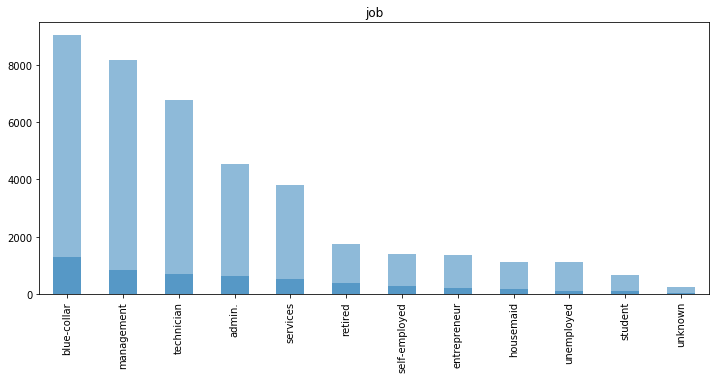

In [69]:
plot_feature = 'job'
axes = bank_data.loc[bank_data['y'] == 1][plot_feature].value_counts().plot(kind='bar',
                                                             alpha=.5,
                                                             figsize=(12, 5),
                                                             title=plot_feature)
bank_data.loc[bank_data['y'] == 0][plot_feature].value_counts().plot(ax=axes, kind='bar', alpha=.5)

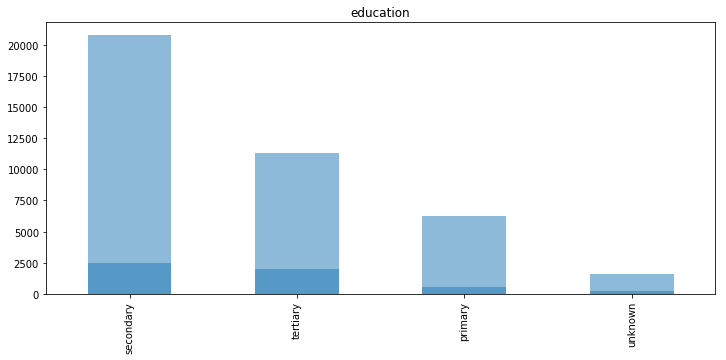

In [70]:
plot_feature = 'education'
axes = bank_data.loc[bank_data['y'] == 1][plot_feature].value_counts().plot(kind='bar',
                                                             alpha=.5,
                                                             figsize=(12, 5),
                                                             title=plot_feature)
bank_data.loc[bank_data['y'] == 0][plot_feature].value_counts().plot(ax=axes, kind='bar', alpha=.5)

In [22]:
# numerical statistics of income data
income_data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456,0.240810
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429,0.427581
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [28]:
# numerical statistics over different classes
income_data.groupby(['income']).describe().T

income                           0             1
age            count  2.472000e+04  7.841000e+03
               mean   3.678374e+01  4.424984e+01
               std    1.402009e+01  1.051903e+01
               min    1.700000e+01  1.900000e+01
               25%    2.500000e+01  3.600000e+01
               50%    3.400000e+01  4.400000e+01
               75%    4.600000e+01  5.100000e+01
               max    9.000000e+01  9.000000e+01
fnlwgt         count  2.472000e+04  7.841000e+03
               mean   1.903409e+05  1.880050e+05
               std    1.064823e+05  1.025418e+05
               min    1.228500e+04  1.487800e+04
               25%    1.176060e+05  1.191010e+05
               50%    1.794650e+05  1.761010e+05
               75%    2.390230e+05  2.309590e+05
               max    1.484705e+06  1.226583e+06
education-num  count  2.472000e+04  7.841000e+03
               mean   9.595065e+00  1.161166e+01
               std    2.436147e+00  2.385129e+00
               min    1.000000e+00  2.000000e+00
               25%    9.000000e+00  1.000000e+01
               50%    9.000000e+00  1.200000e+01
               75%    1.000000e+01  1.300000e+01
               max    1.600000e+01  1.600000e+01
capital-gain   count  2.472000e+04  7.841000e+03
               mean   1.487525e+02  4.006142e+03
               std    9.631393e+02  1.457038e+04
               min    0.000000e+00  0.000000e+00
               25%    0.000000e+00  0.000000e+00
               50%    0.000000e+00  0.000000e+00
               75%    0.000000e+00  0.000000e+00
               max    4.131000e+04  9.999900e+04
capital-loss   count  2.472000e+04  7.841000e+03
               mean   5.314292e+01  1.950015e+02
               std    3.107558e+02  5.954876e+02
               min    0.000000e+00  0.000000e+00
               25%    0.000000e+00  0.000000e+00
               50%    0.000000e+00  0.000000e+00
               75%    0.000000e+00  0.000000e+00
               max    4.356000e+03  3.683000e+03
hours-per-week count  2.472000e+04  7.841000e+03
               mean   3.884021e+01  4.547303e+01
               std    1.231899e+01  1.101297e+01
               min    1.000000e+00  1.000000e+00
               25%    3.500000e+01  4.000000e+01
               50%    4.000000e+01  4.000000e+01
               75%    4.000000e+01  5.000000e+01
               max    9.900000e+01  9.900000e+01

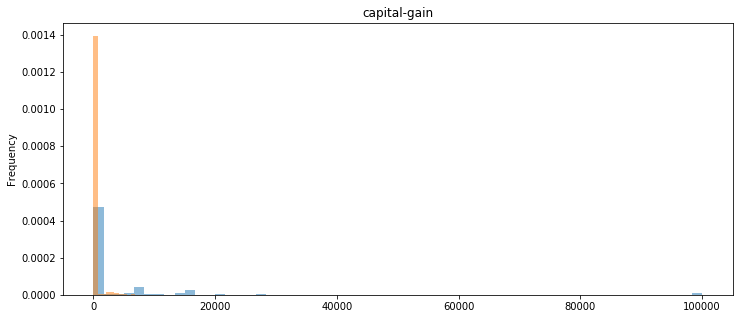

In [52]:
plot_feature = 'capital-gain'
axes = income_data.loc[income_data['income'] == 1][plot_feature].plot(kind='hist',
                                                             alpha=.5,
                                                             density=True,
                                                             bins=60,
                                                             figsize=(12, 5),
                                                             title=plot_feature)
income_data.loc[income_data['income'] == 0][plot_feature].plot(ax=axes, kind='hist', alpha=.5, density=True, bins=60)

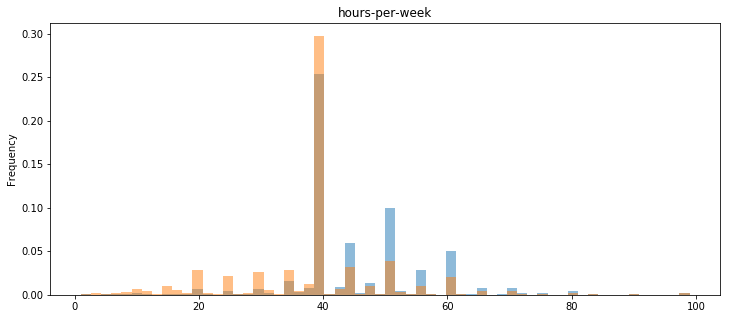

In [55]:
plot_feature = 'hours-per-week'
axes = income_data.loc[income_data['income'] == 1][plot_feature].plot(kind='hist',
                                                             alpha=.5,
                                                             density=True,
                                                             bins=60,
                                                             figsize=(12, 5),
                                                             title=plot_feature)
income_data.loc[income_data['income'] == 0][plot_feature].plot(ax=axes, kind='hist', alpha=.5, density=True, bins=60)

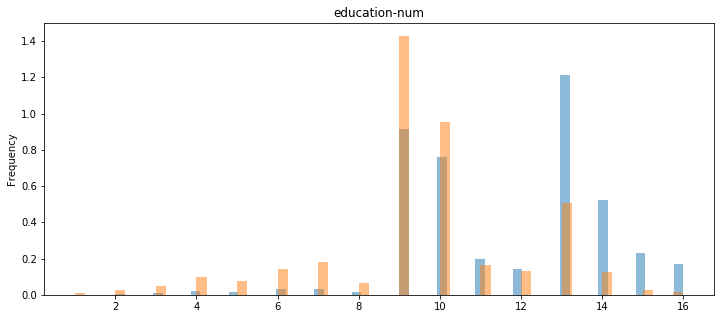

In [78]:
plot_feature = 'education-num'
axes = income_data.loc[income_data['income'] == 1][plot_feature].plot(kind='hist',
                                                             alpha=.5,
                                                             density=True,
                                                             bins=60,
                                                             figsize=(12, 5),
                                                             title=plot_feature)
income_data.loc[income_data['income'] == 0][plot_feature].plot(ax=axes, kind='hist', alpha=.5, density=True, bins=60)

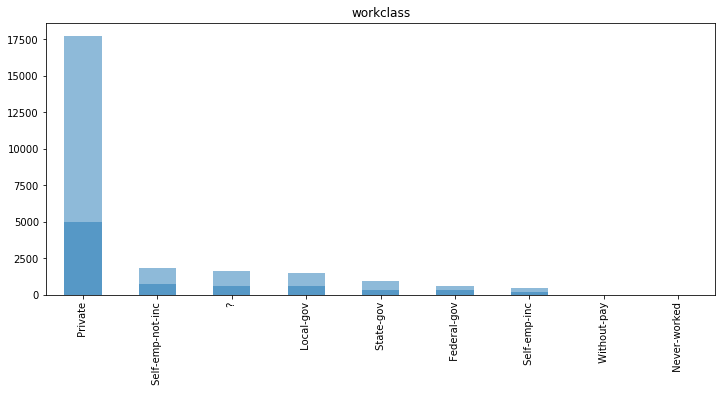

In [76]:
plot_feature = 'workclass'
axes = income_data.loc[income_data['income'] == 1][plot_feature].value_counts().plot(kind='bar',
                                                             alpha=.5,
                                                             figsize=(12, 5),
                                                             title=plot_feature)
income_data.loc[income_data['income'] == 0][plot_feature].value_counts().plot(ax=axes, kind='bar', alpha=.5)

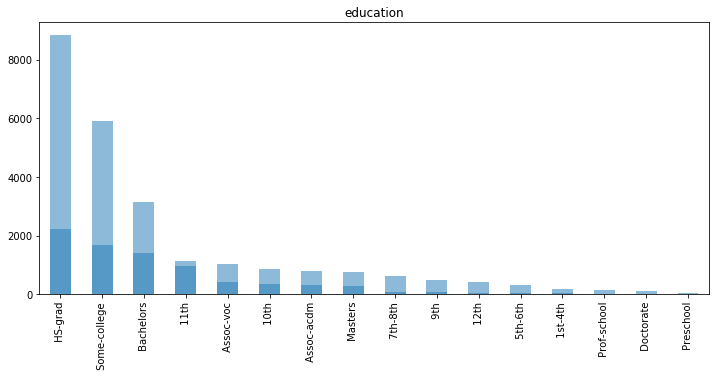

In [75]:
plot_feature = 'education'
axes = income_data.loc[income_data['income'] == 1][plot_feature].value_counts().plot(kind='bar',
                                                             alpha=.5,
                                                             figsize=(12, 5),
                                                             title=plot_feature)
income_data.loc[income_data['income'] == 0][plot_feature].value_counts().plot(ax=axes, kind='bar', alpha=.5)

Based on these statistical summary and plots, we can conclude that applying some simple transformation on features will be helpful, such as logarithm, this will help to distinguish different classes using these features.

- What properties lead to different algorithms’ performance? How robust is their performance;
what would cause it to degrade?

There are multiple things leaf to the differences among algorithms' performance: training data, hyperparameters, training strategies. We can see that random forest can provide the most robust performance among different hyperparameters, and multilayer perceptron has the least robust performance among different hyperparameters - it could perform better than random forest and it could also perform worse than SVM. The reason is already mentioned in one of the previous question - theoretically multilayer perceptron is more likely to overfit.

- What have you learned about your data? What real-world problems could your insights be
useful for? In what ways is your data representative of a real-world problem, and it what
ways is it not?

As we can see that random forest and multilayer perceptron can generally perform better than SVM, this means the data is not very well separated, the decision boundary between two classes could be very complex. This is very common in real-world problems, the data will be extremely imbalanced, the data are not very well separated, and there are no strong features are helpful to classify the target. These two datasets we have are very cleaned data, where in real-world we will usually have raw data with bad and missing values.

- Do you have any recommendations for someone faced with this real-world problem? (Suggested algorithm/hyperparameters, data collection methods, etc.)

For this real-world problem, we will recommend use random forest as the baseline algorithm, usually the default settings provided by `sklearn` is a good start. As we can see random forest can give better results than SVM and multilayer perceptron (in some cases), also random forest can be trained very fast on this size of the data. In addition, random forest can also output feature importance which will be helpful for feature engineering and model evaluation.

- Provide qualitative analysis of performance - show examples that the algorithm fails on, and
examples of successes. Are the ’hard’ and ’easy’ examples in the dataset the same for different
algorithms?

As we mentioned in one of the above questions, the performance of models can be determined by the data. Therefore if there is a dataset which the classes are linear separated, SVM with linear kernel function could achieve very good results, while random forest and multilayer perceptron could be overfit.

- What are some other phenomena or interesting questions you would recommend for further
work/experiments?

There are several topics we'd like to continue if we have more time:

```
1. How much improvement can be achieved with some feature engineering?
2. What are the feature importance? i.e. which feature sets contribute the most for classifying classes
3. Try more different models / algorithms
```